In [0]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files 
import json
%matplotlib inline

import xml.etree.ElementTree as ET
!ls

sample_data


In [0]:
uploaded=files.upload()
for filename in uploaded.keys():
    print('Upload {} : {}'.format(filename,len(uploaded[filename])))

with open('./kaggle.json') as json_file:
    api_token=json.loads(json_file.read())
os.environ['KAGGLE_USERNAME']=api_token['username']
os.environ['KAGGLE_KEY']=api_token['key']
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset --unzip --force

Saving kaggle.json to kaggle.json
Upload kaggle.json : 64
 99% 746M/750M [00:09<00:00, 85.7MB/s]
100% 750M/750M [00:09<00:00, 79.1MB/s]


In [0]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
device

device(type='cuda')

In [0]:
def crop_image(breed,dog,data_dir):
    img=plt.imread(os.path.join(data_dir,'images','Images',breed,dog)+'.jpg')
    tree=ET.parse(os.path.join(data_dir,'annotations','Annotation',breed,dog))
    xmin=int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax=int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin=int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax=int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img=img[ymin:ymax,xmin:xmax,:]
    return img

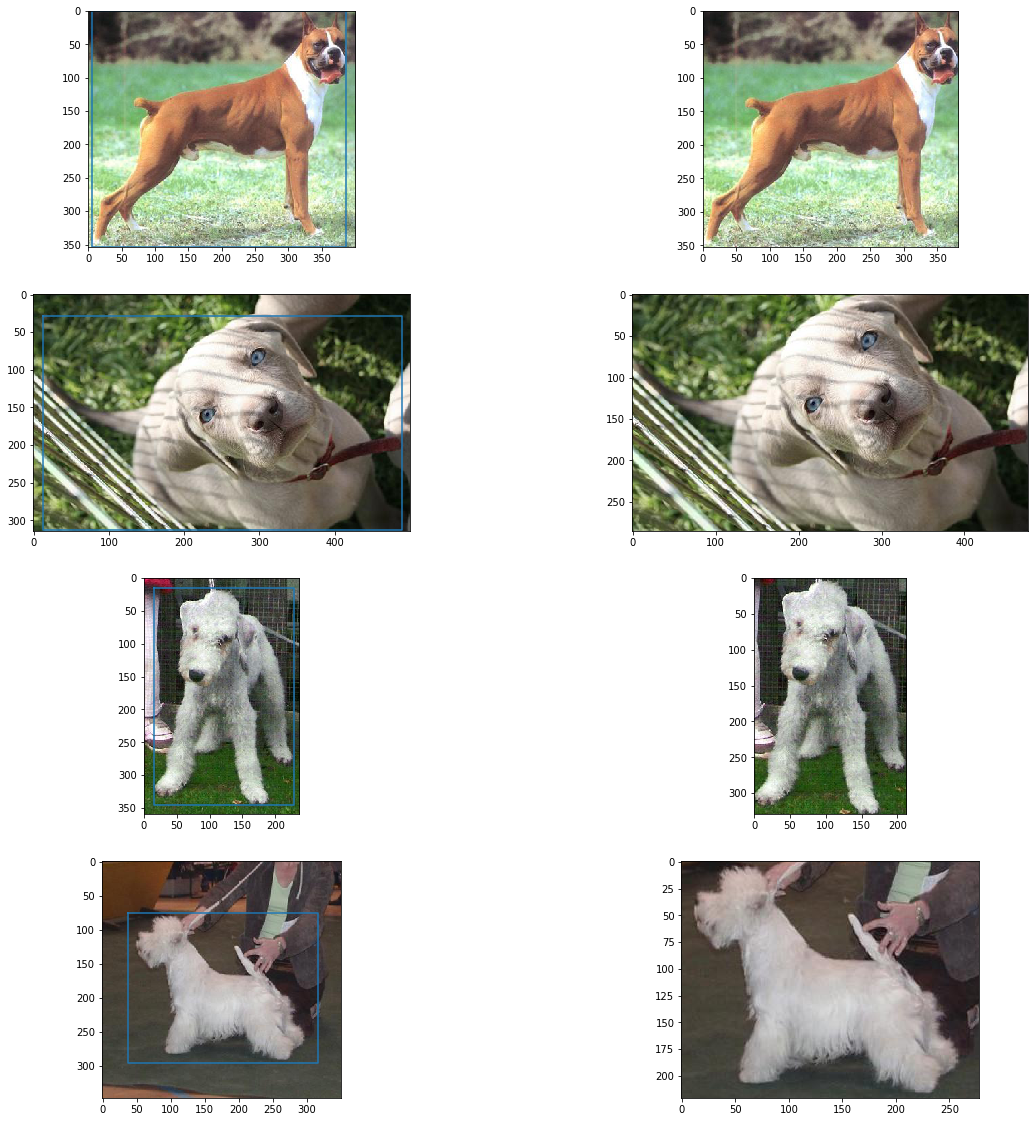

In [0]:
data_dir='.'
breed_list=os.listdir(os.path.join(data_dir,'images','Images'))
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(421+(i*2))
    breed=np.random.choice(breed_list)
    dog=np.random.choice(os.listdir(os.path.join(data_dir,'annotations','Annotation',breed)))
    img=plt.imread(os.path.join(data_dir,'images','Images',breed,dog)+'.jpg')
    plt.imshow(img)
    tree=ET.parse(os.path.join(data_dir,'annotations','Annotation',breed,dog))
    xmin=int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax=int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin=int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax=int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    plt.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin])
    crop_img=crop_image(breed,dog,data_dir)
    plt.subplot(422+(i*2))
    plt.imshow(crop_img)

In [0]:
if 'data' not in os.listdir():
    os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

Created 120 folders to store cropped images of the different breeds.


In [0]:
for breed in os.listdir('data'):
    for file in os.listdir(os.path.join(data_dir,'annotations','Annotation', breed)):
        img = Image.open(os.path.join(data_dir,'images','Images',breed, file)+'.jpg')
        tree = ET.parse(os.path.join(data_dir,'annotations','Annotation',breed,file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data/' + breed + '/' + file + '.jpg')

In [0]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [0]:
batch_size = 128

all_data = datasets.ImageFolder(root='data')
train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['test']
test_data.dataset.transform = image_transforms['test']
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

16464 2058 2058


In [0]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [0]:
model = models.vgg16(pretrained=True)

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
n_classes = 120
in_features=model.classifier[6].in_features
model.classifier[6]=nn.Linear(in_features,n_classes)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [0]:
model.class_to_idx=all_data.class_to_idx
model.idx_to_class={
    idx:class_ for class_,idx in model.class_to_idx.items()
}
list(model.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


In [0]:
def train(model,
         criterion,
         optimizer,
         train_loader,
         val_loader,
         save_location,
         early_stop=3,
         n_epochs=20,
         print_every=2):
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1) 
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        model.epochs += 1
        with torch.no_grad():
            model.eval()

            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                torch.save({
                    'state_dict': model.state_dict(),
                    'idx_to_class': model.idx_to_class
                }, save_location)
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                stop_count += 1

                if stop_count >= early_stop:
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history

    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [0]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='./dog_inception.pt',
    early_stop=3,
    n_epochs=30,
    print_every=1)

Epoch: 0	8.53% complete.
Epoch: 0	16.28% complete.
Epoch: 0	24.03% complete.
Epoch: 0	31.78% complete.
Epoch: 0	39.53% complete.
Epoch: 0	47.29% complete.
Epoch: 0	55.04% complete.
Epoch: 0	62.79% complete.
Epoch: 0	70.54% complete.
Epoch: 0	78.29% complete.
Epoch: 0	86.05% complete.
Epoch: 0	93.80% complete.

Epoch: 0 	Training Loss: 1.5455 	Validation Loss: 0.8634
		Training Accuracy: 61.84%	 Validation Accuracy: 76.68%
Epoch: 1	8.53% complete.
Epoch: 1	16.28% complete.
Epoch: 1	24.03% complete.
Epoch: 1	31.78% complete.
Epoch: 1	39.53% complete.
Epoch: 1	47.29% complete.
Epoch: 1	55.04% complete.
Epoch: 1	62.79% complete.
Epoch: 1	70.54% complete.
Epoch: 1	78.29% complete.
Epoch: 1	86.05% complete.
Epoch: 1	93.80% complete.

Epoch: 1 	Training Loss: 0.7788 	Validation Loss: 0.7690
		Training Accuracy: 76.56%	 Validation Accuracy: 76.87%
Epoch: 2	8.53% complete.
Epoch: 2	16.28% complete.
Epoch: 2	24.03% complete.
Epoch: 2	31.78% complete.
Epoch: 2	39.53% complete.
Epoch: 2	47.29% com

In [0]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,1.545494,0.863358,0.618440,0.766764
1,0.778788,0.768983,0.765610,0.768707
2,0.673491,0.742212,0.792881,0.773567
3,0.602164,0.730989,0.809281,0.780369
4,0.550566,0.718914,0.825923,0.783771
5,0.516542,0.717222,0.836735,0.784257
6,0.476007,0.718686,0.843598,0.782313
7,0.450560,0.724770,0.851616,0.778426
8,0.422673,0.730799,0.863399,0.781827


In [0]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [0]:
model.load_state_dict(torch.load('./dog_inception.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

The model has achieved an accuracy of 77.26% on the test dataset


In [0]:
def evaluate(model, test_loader, criterion):
  
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            output = model(data)

            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()][10:])
                i+=1

    results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
    })
    results = results.groupby(classes).mean()

    return results

In [0]:
print(evaluate(model, test_loader, criterion))

                                 results
Afghan_hound                    0.833333
African_hunting_dog             0.904762
Airedale                        0.720000
American_Staffordshire_terrier  0.444444
Appenzeller                     0.555556
...                                  ...
toy_poodle                      0.812500
toy_terrier                     0.833333
vizsla                          0.583333
whippet                         0.608696
wire-haired_fox_terrier         0.812500

[120 rows x 1 columns]
